In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn-v0_8")

class MeanRevBacktester():

    def __init__(self,symbol,SMA, dev, start, end, tc):

        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.prepare_data()


    def __repr__(self):
        return "MeanRevBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {}, tc = {})".format(self.symbol, self.SMA, self.dev, self.start, self.end, self.tc)

    def get_data(self):
        raw = pd.read_csv("/Users/user/Desktop/Part3_Materials/intraday_pairs.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns = {self.symbol: "price"}, inplace = True)
        raw["returns"] = np.log(raw/raw.shift(1))
        self.data = raw

    def prepare_data(self):
        data = self.data.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std()*self.dev
        data["Higher"] = data["SMA"] + data["price"].rolling(self.SMA).std()*self.dev
        self.data = data

    def set_parameters(self, SMA = None, dev = None):
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std()*self.dev
            self.data["Higher"] = data["SMA"] + data["price"].rolling(self.SMA).std()*self.dev

        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std()*self.dev
            self.data["Higer"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std()*self.dev

    def test_strategy(self):

        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower,1 ,np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["postion"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0,0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.poistion.shift(1)*data["returns"]
        data.dropna(inplace = True)

        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy - data.trades * self.tc

        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data

        perf = data["cstrategy"].iloc[-1]
        outperf = perf - data["creturns"].iloc[-1]

        return round(perf, 6) ,round(outperf, 6)

    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() first")

        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))     

    def optimize_parameters(self, SMA_range, dev_range):

        combinations = list(product(range(*SMA_range),range(*dev_range)))

        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])

        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]

        self.set_parameters(opt[0], opt[1])
        self.test_strtategy()

        many_results = pd.DataFrame(data = combinations, columns = ["SMA", "dec"])
        many_results["performance"] = results
        self.results_overview = many_results

        return opt, best_perf
                                                                                                          
                                                                                                          
                                                                                                          
                                                                                            

In [1]:
import MeanRevBacktester as MeanRev

In [2]:
tester = MeanRev.MeanRevBacktester("EURUSD", 30, 2, "2018-01-01", "2019-12-31",0.00007)

In [3]:
tester

MeanRevBacktester(symbol = EURUSD, SMA = 30, dev = 2, start = 2018-01-01, end = 2019-12-31)

In [4]:
tester.test_strategy()

(1.069792, 0.132076)

In [5]:
tester.optimize_parameters((5,50,1), (1,5,1))

((43, 2), 1.211452)

In [7]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,
2018-01-16 16:00:00+00:00,1.226070,0.002540,1.206296,1.185220,1.227371,0.019774,0.0,0.000000,0.0,1.002543,1.000000
2018-01-16 22:00:00+00:00,1.226720,0.000530,1.206753,1.184776,1.228730,0.019967,0.0,0.000000,0.0,1.003075,1.000000
2018-01-17 04:00:00+00:00,1.223655,-0.002502,1.207200,1.184641,1.229758,0.016455,0.0,-0.000000,0.0,1.000568,1.000000
2018-01-17 10:00:00+00:00,1.224275,0.000507,1.207630,1.184484,1.230775,0.016645,0.0,0.000000,0.0,1.001075,1.000000
2018-01-17 16:00:00+00:00,1.218540,-0.004695,1.207952,1.184589,1.231314,0.010588,0.0,-0.000000,0.0,0.996386,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.112280,1.106117,1.118443,0.007640,-1.0,-0.000070,1.0,0.915745,1.211922
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.112471,1.105884,1.119059,0.007469,-1.0,-0.000018,0.0,0.915762,1.211900
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.112634,1.105650,1.119619,0.007461,-1.0,-0.000138,0.0,0.915889,1.211733


In [8]:
tester.results_overview

,SMA,dev,performance
0,5,1,0.958656
1,5,2,1.000000
2,5,3,1.000000
3,5,4,1.000000
4,6,1,0.920298
...,...,...,...
175,48,4,1.000000
176,49,1,1.180364
177,49,2,1.162028
178,49,3,1.057143


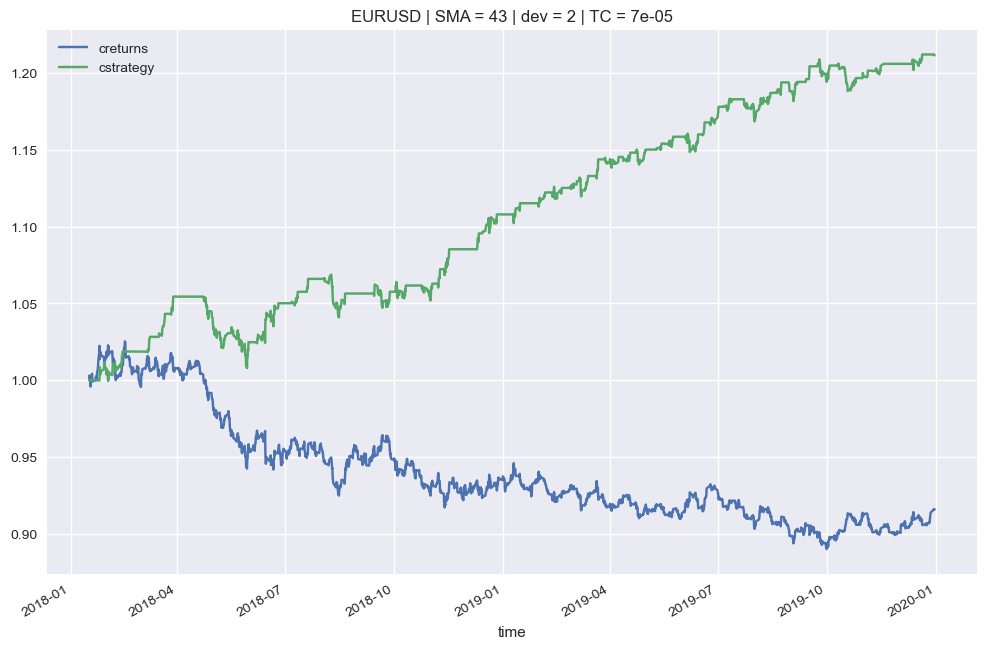

In [10]:
tester.plot_results()